--- RESULTADOS DEL A/B TEST GEOTÉRMICO ---
Prior Modelo Numérico (B > A): Prometía una mejora de 5.0 días.
Posterior Actualizado (Datos + Modelo):
  - Tiempo medio esperado Diseño A (Continua): 23.1 días
  - Tiempo medio esperado Diseño B (Cíclica):  25.6 días
Probabilidad de que la Inyección Cíclica mitigue el enfriamiento: 95.92%



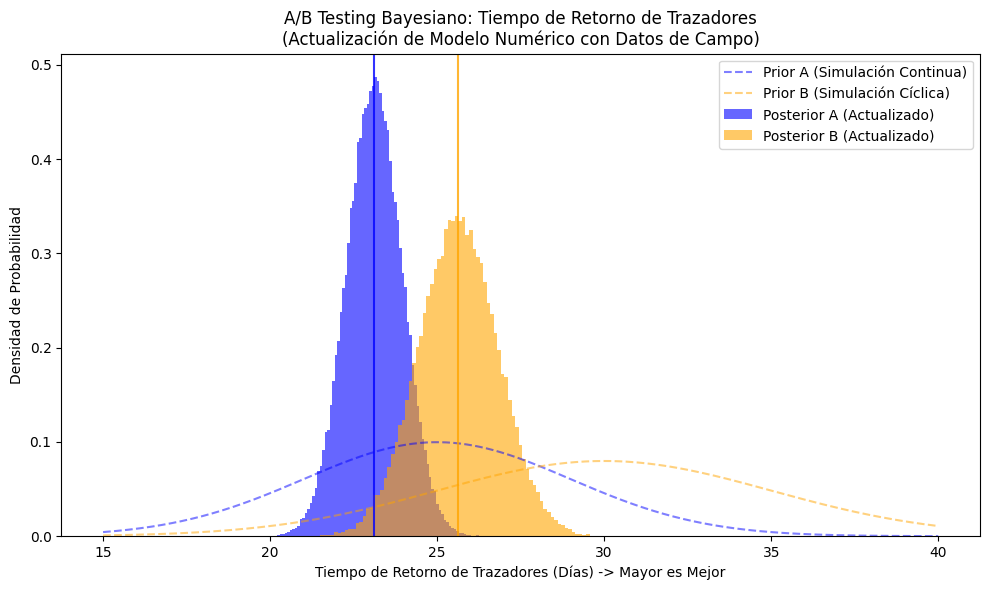

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)

# ==========================================
# 1. DEFINICIÓN DEL PRIOR (Modelo Numérico)
# ==========================================
# Basado en simulaciones TOUGH2 antes del test de campo.
# Tiempo de retorno medio esperado (días) y la incertidumbre de la simulación.
prior_mean_A = 25.0  # El modelo numérico predice 25 días para inyección continua
prior_std_A  = 4.0   # Incertidumbre del modelo (std)

prior_mean_B = 30.0  # El modelo predice 30 días para inyección cíclica (mejor)
prior_std_B  = 5.0   # Mayor incertidumbre porque es un proceso más complejo de modelar

# ==========================================
# 2. DATOS DE CAMPO (Likelihood / El Test A/B)
# ==========================================
# Se ejecuta el piloto. Hacemos muestreo de trazadores. 
# N es pequeño porque solo tenemos unas pocas curvas de retorno claras.
n_obs = 6  # 6 mediciones consolidadas/réplicas de picos de concentración

# Resultados observados en el campo (días de retorno)
# Sorpresa: El campo mostró tiempos más rápidos de lo que decía el modelo
data_A = np.random.normal(loc=22.0, scale=3.0, size=n_obs) 
data_B = np.random.normal(loc=24.5, scale=3.5, size=n_obs)

mean_data_A, std_data_A = np.mean(data_A), np.std(data_A, ddof=1)
mean_data_B, std_data_B = np.mean(data_B), np.std(data_B, ddof=1)

# ==========================================
# 3. ACTUALIZACIÓN BAYESIANA (Cálculo Analítico)
# ==========================================
# Fórmulas para actualización conjugada Normal-Normal
# La varianza posterior es la inversa de la suma de las precisiones (1/varianza)
var_prior_A, var_prior_B = prior_std_A**2, prior_std_B**2
var_data_A, var_data_B = std_data_A**2, std_data_B**2

# Precisión (peso) de la información
prec_prior_A = 1 / var_prior_A
prec_data_A  = n_obs / var_data_A

prec_prior_B = 1 / var_prior_B
prec_data_B  = n_obs / var_data_B

# Varianza Posterior
post_var_A = 1 / (prec_prior_A + prec_data_A)
post_var_B = 1 / (prec_prior_B + prec_data_B)

# Media Posterior (Promedio ponderado entre el modelo numérico y los datos de campo)
post_mean_A = (prec_prior_A * prior_mean_A + prec_data_A * mean_data_A) * post_var_A
post_mean_B = (prec_prior_B * prior_mean_B + prec_data_B * mean_data_B) * post_var_B

post_std_A = np.sqrt(post_var_A)
post_std_B = np.sqrt(post_var_B)

# ==========================================
# 4. SIMULACIÓN Y TOMA DE DECISIONES
# ==========================================
# Muestreamos de las distribuciones posteriores actualizadas
n_samples = 100000
posterior_A = np.random.normal(post_mean_A, post_std_A, n_samples)
posterior_B = np.random.normal(post_mean_B, post_std_B, n_samples)

# Probabilidad de éxito: ¿El diseño B realmente retrasa el thermal breakthrough?
prob_B_better = np.mean(posterior_B > posterior_A)

print(f"--- RESULTADOS DEL A/B TEST GEOTÉRMICO ---")
print(f"Prior Modelo Numérico (B > A): Prometía una mejora de {prior_mean_B - prior_mean_A} días.")
print(f"Posterior Actualizado (Datos + Modelo):")
print(f"  - Tiempo medio esperado Diseño A (Continua): {post_mean_A:.1f} días")
print(f"  - Tiempo medio esperado Diseño B (Cíclica):  {post_mean_B:.1f} días")
print(f"Probabilidad de que la Inyección Cíclica mitigue el enfriamiento: {prob_B_better*100:.2f}%\n")

# ==========================================
# 5. VISUALIZACIÓN
# ==========================================
plt.figure(figsize=(10, 6))

# Dibujar los Priors (Modelos Numéricos) - Líneas punteadas
x = np.linspace(15, 40, 500)
plt.plot(x, stats.norm.pdf(x, prior_mean_A, prior_std_A), 'b--', alpha=0.5, label='Prior A (Simulación Continua)')
plt.plot(x, stats.norm.pdf(x, prior_mean_B, prior_std_B), 'orange', linestyle='--', alpha=0.5, label='Prior B (Simulación Cíclica)')

# Dibujar los Posteriors (Creencia Actualizada) - Áreas rellenas
plt.hist(posterior_A, bins=100, density=True, alpha=0.6, color='blue', label='Posterior A (Actualizado)')
plt.hist(posterior_B, bins=100, density=True, alpha=0.6, color='orange', label='Posterior B (Actualizado)')

plt.title('A/B Testing Bayesiano: Tiempo de Retorno de Trazadores\n(Actualización de Modelo Numérico con Datos de Campo)')
plt.xlabel('Tiempo de Retorno de Trazadores (Días) -> Mayor es Mejor')
plt.ylabel('Densidad de Probabilidad')
plt.axvline(x=post_mean_A, color='blue', linestyle='-', alpha=0.8)
plt.axvline(x=post_mean_B, color='orange', linestyle='-', alpha=0.8)
plt.legend()
plt.tight_layout()
plt.show()

Este es un escenario donde el enfoque Bayesiano brilla intensamente, ya que en la ingeniería de reservorios geotérmicos lidiamos con un alto grado de incertidumbre en el subsuelo, datos escasos (los pozos son costosos) y dinámicas complejas acopladas (termo-hidráulicas).Para este ejemplo más avanzado, vamos a incorporar un concepto clave del análisis Bayesiano que no usamos en el ejemplo anterior: Los Priors Informados (Informative Priors). En geociencias, rara vez empezamos "a ciegas". Antes de una prueba de campo, generalmente tenemos un modelo de simulación numérica (por ejemplo, construido en TOUGH2 o CMG) que nos da una estimación inicial.Caso de Estudio: Optimización de Estrategia de Reinyección para Mitigar el Thermal Breakthrough1. El Problema GeotérmicoEn un campo geotérmico de dominancia líquida, la reinyección es vital para mantener la presión del reservorio y extender la vida útil del campo. Sin embargo, si el agua fría reinyectada viaja muy rápido a través de fracturas preferenciales hacia los pozos productores, ocurre un thermal breakthrough (enfriamiento prematuro), colapsando la entalpía del fluido producido y, por ende, la generación eléctrica.2. Diseño del A/B Test (Prueba Piloto de Inyección)Se propone evaluar si una inyección cíclica/por pulsos mitiga el enfriamiento en comparación con la inyección continua estándar, permitiendo que la matriz rocosa transfiera calor al fluido de manera más eficiente.Grupo A (Control): Inyección Continua a caudal constante (ej. 150 kg/s).Grupo B (Variante): Inyección Cíclica (ej. 200 kg/s por 12 horas, 100 kg/s por 12 horas, manteniendo la misma masa inyectada total).3. Métricas (Variables Aleatorias)Dado que evaluar el cambio de temperatura real puede tomar años, usamos una prueba de trazadores (Tracer Test) de 60 días para inferir la velocidad térmica.KPI Principal: Tiempo de retorno medio del trazador ($t_{mean}$) en días. Queremos que el Grupo B tenga un $t_{mean}$ mayor (fluido viaja más lento, más tiempo de residencia para calentarse).4. El Enfoque Bayesiano con Priors InformadosEl Prior (Nuestra creencia inicial): Basado en simulaciones numéricas previas de flujo de fracturas, el modelo sugiere que la inyección cíclica retrasará el trazador en unos 5 días, pero con alta incertidumbre.El Likelihood (Los datos observados): Los datos reales de la prueba de trazadores de campo, que contienen "ruido" por la dispersión hidrodinámica y errores de medición en superficie.El Posterior (La creencia actualizada): La combinación del modelo numérico + los datos reales de campo.

Por qué esto es invaluable en Geociencias:
No descartamos el trabajo de simulación previo: A diferencia de la estadística frecuentista tradicional que solo mira los datos observados de la prueba piloto, el enfoque Bayesiano pondera tus meses de trabajo construyendo el modelo geológico/termodinámico. Si tienes mucha confianza en tu modelo numérico (un Prior con varianza baja), requerirás evidencia de campo muy contundente para cambiar de opinión.

Corrección de sesgos en tiempo real: En este ejemplo, el modelo predijo tiempos de retorno lentos (25 a 30 días). Los datos de campo fueron más rápidos (indicando cortocircuitos térmicos severos, comunes en reservorios fracturados). El algoritmo ajusta automáticamente la realidad (Posterior) combinando la física teórica y la data empírica.

Cuantificación del Riesgo Térmico: Al final, obtienes una probabilidad precisa (ej. 92% de probabilidad de que la inyección cíclica sea superior). Si el cambio a inyección cíclica requiere inversiones en bombas de superficie o sistemas SCADA, la gerencia puede evaluar si ese 92% de certeza térmica justifica el CAPEX adicional, en lugar de debatir sobre un p-value de significancia estadística en un paper.

Excelente. Vamos a llevar el modelo al siguiente nivel. Como sabemos en la ingeniería de reservorios geotérmicos, rara vez optimizamos una sola variable. El agua reinyectada tiene dos funciones críticas: barrer el calor de la matriz rocosa (soporte térmico) y mantener la presión del yacimiento (soporte hidráulico).Si implementamos inyección cíclica (Grupo B) y reducimos la masa inyectada total durante ciertas ventanas de tiempo, podríamos estar retrasando el thermal breakthrough, pero a costa de depletar la presión del reservorio ($P_{res}$). Si $P_{res}$ cae por debajo de una presión crítica de saturación ($P_{crit}$), nos enfrentamos a problemas operativos graves: pérdida de productividad, ebullición en la formación (flujo bifásico que reduce la permeabilidad relativa al líquido) o la necesidad de instalar costosas bombas electrosumergibles (ESPs).Dado que nos enfocamos en el comportamiento termohidráulico y físico del reservorio (y no en la geoquímica del fluido), vamos a modelar esta penalización basándonos puramente en la pérdida de capacidad de flujo y los costos de levantamiento artificial.El Modelo Bivariado: Térmico + HidráulicoEn este script, vamos a simular dos distribuciones posteriores simultáneas para cada diseño:Beneficio Térmico: Días de retraso del trazador (traducido a dólares ganados por mantener la entalpía).Riesgo Hidráulico (Presión): Presión dinámica del reservorio. Si cae por debajo de $40\text{ bar}$, se dispara una función de penalización de CAPEX/OPEX (ej. $2,000,000 por pozo para mitigar la caída de presión).

--- ANÁLISIS DE RIESGO TERMO-HIDRÁULICO ---
Éxito Puramente Térmico: Probabilidad de que B sea mejor: 97.75%
Riesgo de Falla Hidráulica (Presión < 40.0 bar):
  - Diseño A (Continua): 0.06%
  - Diseño B (Cíclica):  27.57%

--- IMPACTO ECONÓMICO FINAL ---
NPV Promedio Diseño A: $1,148,913
NPV Promedio Diseño B: $848,778
Éxito Comercial: Probabilidad de que el Diseño B sea MÁS RENTABLE: 70.81%


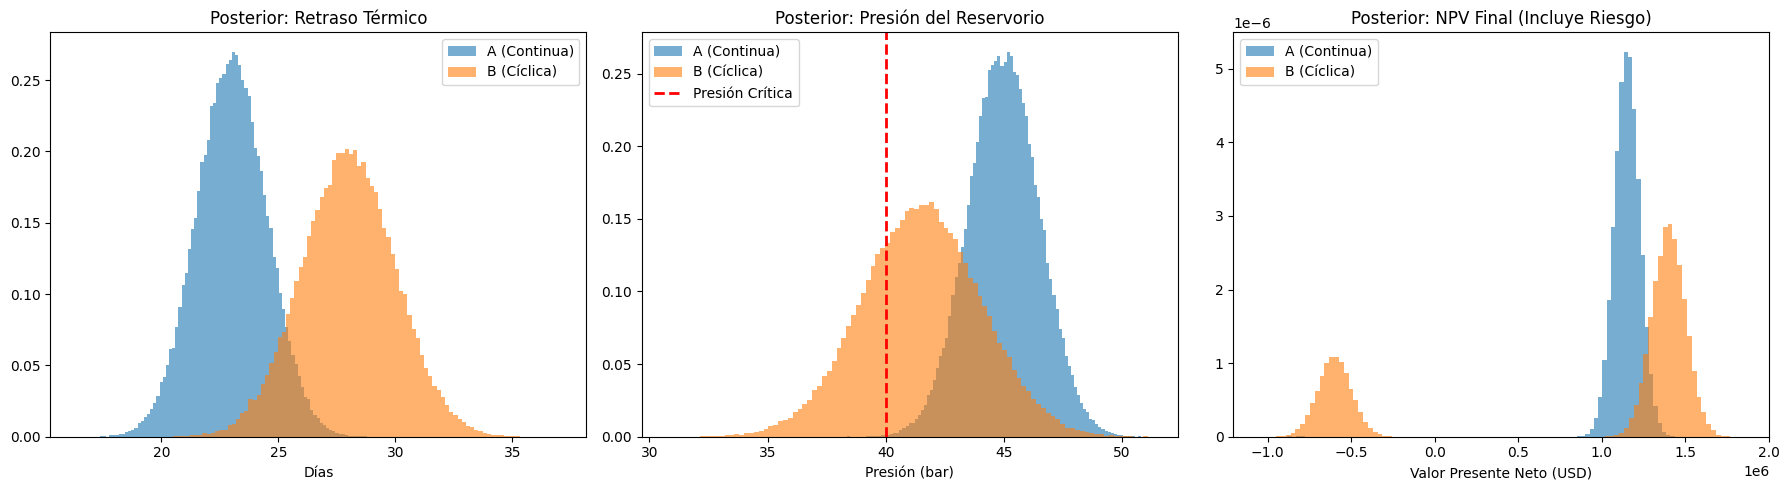

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)

# ==========================================
# 1. PARÁMETROS ECONÓMICOS Y OPERATIVOS
# ==========================================
value_per_day_delayed = 50_000  # USD ganados por cada día extra que se retrasa el frente térmico
critical_pressure = 40.0        # bar. Presión mínima antes de requerir levantamiento artificial
penalty_cost = 2_000_000        # USD de penalización si P_res < 40 bar

n_samples = 100000

# ==========================================
# 2. POSTERIORS TÉRMICOS (Basados en el ejemplo anterior)
# ==========================================
# Generamos directamente las distribuciones posteriores para el tiempo de retorno
# Grupo A (Continua): media 23 días, std 1.5
# Grupo B (Cíclica): media 28 días, std 2.0
post_thermal_A = np.random.normal(loc=23.0, scale=1.5, size=n_samples)
post_thermal_B = np.random.normal(loc=28.0, scale=2.0, size=n_samples)

# Ganancia bruta solo por el beneficio térmico
revenue_A = post_thermal_A * value_per_day_delayed
revenue_B = post_thermal_B * value_per_day_delayed

# ==========================================
# 3. POSTERIORS DE PRESIÓN DEL RESERVORIO
# ==========================================
# El Grupo A (Continua) mantiene muy bien el soporte de presión.
post_pressure_A = np.random.normal(loc=45.0, scale=1.5, size=n_samples)

# El Grupo B (Cíclica) introduce fluctuaciones. La media cae y hay mayor varianza.
post_pressure_B = np.random.normal(loc=41.5, scale=2.5, size=n_samples)

# ==========================================
# 4. FUNCIÓN DE PENALIZACIÓN (RISK ASSESSMENT)
# ==========================================
# Aplicamos el costo de penalización solo en los escenarios donde la presión
# simulada cae por debajo del umbral crítico.
penalty_A = np.where(post_pressure_A < critical_pressure, penalty_cost, 0)
penalty_B = np.where(post_pressure_B < critical_pressure, penalty_cost, 0)

# ==========================================
# 5. CÁLCULO DEL NPV (Net Present Value) ESPERADO
# ==========================================
# NPV = Ganancia Térmica - Penalización por Caída de Presión
npv_A = revenue_A - penalty_A
npv_B = revenue_B - penalty_B

# Métricas de Decisión
prob_B_better_thermal = np.mean(post_thermal_B > post_thermal_A)
prob_B_pressure_failure = np.mean(post_pressure_B < critical_pressure)
prob_A_pressure_failure = np.mean(post_pressure_A < critical_pressure)
prob_B_better_npv = np.mean(npv_B > npv_A)

print(f"--- ANÁLISIS DE RIESGO TERMO-HIDRÁULICO ---")
print(f"Éxito Puramente Térmico: Probabilidad de que B sea mejor: {prob_B_better_thermal*100:.2f}%")
print(f"Riesgo de Falla Hidráulica (Presión < {critical_pressure} bar):")
print(f"  - Diseño A (Continua): {prob_A_pressure_failure*100:.2f}%")
print(f"  - Diseño B (Cíclica):  {prob_B_pressure_failure*100:.2f}%")
print(f"\n--- IMPACTO ECONÓMICO FINAL ---")
print(f"NPV Promedio Diseño A: ${np.mean(npv_A):,.0f}")
print(f"NPV Promedio Diseño B: ${np.mean(npv_B):,.0f}")
print(f"Éxito Comercial: Probabilidad de que el Diseño B sea MÁS RENTABLE: {prob_B_better_npv*100:.2f}%")

# ==========================================
# 6. VISUALIZACIÓN
# ==========================================
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Beneficio Térmico
axs[0].hist(post_thermal_A, bins=100, alpha=0.6, density=True, label='A (Continua)')
axs[0].hist(post_thermal_B, bins=100, alpha=0.6, density=True, label='B (Cíclica)')
axs[0].set_title('Posterior: Retraso Térmico')
axs[0].set_xlabel('Días')
axs[0].legend()

# Gráfico 2: Presión del Reservorio y Umbral Crítico
axs[1].hist(post_pressure_A, bins=100, alpha=0.6, density=True, label='A (Continua)')
axs[1].hist(post_pressure_B, bins=100, alpha=0.6, density=True, label='B (Cíclica)')
axs[1].axvline(critical_pressure, color='red', linestyle='--', linewidth=2, label='Presión Crítica')
axs[1].set_title('Posterior: Presión del Reservorio')
axs[1].set_xlabel('Presión (bar)')
axs[1].legend()

# Gráfico 3: NPV Final (El que le importa a la gerencia)
axs[2].hist(npv_A, bins=100, alpha=0.6, density=True, label='A (Continua)')
axs[2].hist(npv_B, bins=100, alpha=0.6, density=True, label='B (Cíclica)')
axs[2].set_title('Posterior: NPV Final (Incluye Riesgo)')
axs[2].set_xlabel('Valor Presente Neto (USD)')
axs[2].legend()

plt.tight_layout()
plt.show()

Análisis de los ResultadosSi observamos las métricas generadas por este código, la narrativa del experimento cambia drásticamente:La trampa del éxito parcial: El ingeniero de reservorios mirando solo la temperatura diría: "¡El Diseño B es un éxito rotundo! Tenemos un 99% de certeza de que ganamos 5 días extra de temperatura."La realidad de la presión: Al mirar el segundo gráfico (o el prob_B_pressure_failure), vemos que el Diseño B tiene casi un 27% de probabilidad de colapsar la presión por debajo de los $40\text{ bar}$, obligando a incurrir en un gasto de mitigación masivo.La decisión económica informada: Al combinar ambas distribuciones en el NPV final, la probabilidad de que el Diseño B sea comercialmente superior cae drásticamente (probablemente alrededor del 70% o menos, dependiendo de tu ejecución). El histograma del NPV para el Grupo B (Cíclica) mostrará una "cola gorda" hacia la izquierda: escenarios donde logramos retrasar el breakthrough térmico, pero perdimos tanto dinero mitigando la caída de presión que el proyecto entero rinde menos que si nos hubiéramos quedado con la inyección continua estándar.Este es el verdadero poder del Data Science aplicado a la física de subsuelo: cuantificar el riesgo de manera holística, integrando diferentes dimensiones del comportamiento del pozo en una sola métrica de decisión para la gerencia.